# Dissection of the life-table QALY calculation

*Original code by Juan Pablo Gallo. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2022 by BIOMATH, Ghent University. All Rights Reserved.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Define the comorbidity profile of the studied population

In [4]:
iterables = [pd.IntervalIndex.from_tuples([(0,20),(20,60),(60,120)], closed='left'),['delta_QoL', 'SMR']]
index = pd.MultiIndex.from_product(iterables, names=['age_group', 'metric'])
comorbidity_parameters = pd.DataFrame(index=index, columns=['comorbid_low','comorbid_high'])
comorbidity_parameters.columns.name = 'population'
comorbidity_parameters.loc[(slice(None),'SMR'),:] = [0.5, 2]
comorbidity_parameters.loc[(slice(None),'delta_QoL'),:] = [0.05, -0.05]

In [5]:
comorbidity_parameters

population          comorbid_low comorbid_high
age_group metric                              
[0, 20)   delta_QoL         0.05         -0.05
          SMR                0.5             2
[20, 60)  delta_QoL         0.05         -0.05
          SMR                0.5             2
[60, 120) delta_QoL         0.05         -0.05
          SMR                0.5             2

### Initialize the QALY_model object

In [6]:
from covid19model.models.QALY import life_table_QALY_model
QALY_model = life_table_QALY_model(comorbidity_parameters)

### Compute and visualize survival functions and life expectancy

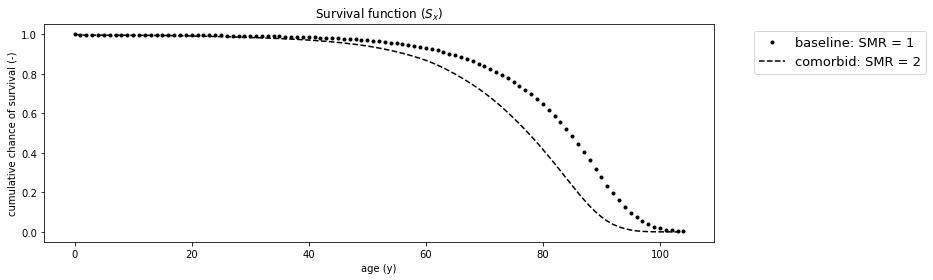

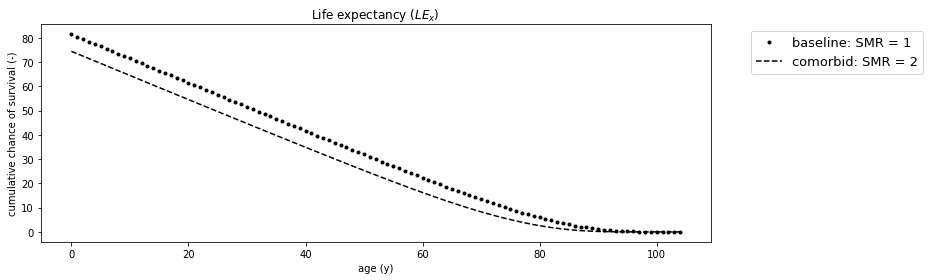

In [7]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_comorbid=2
ax.set_title('Survival function ($S_x$)')
ax.set_ylabel('cumulative chance of survival (-)')
ax.set_xlabel('age (y)')
ax.plot(QALY_model.survival_function(SMR=1),'.',color='black')
ax.plot(QALY_model.survival_function(SMR=SMR_comorbid),'--',color='black')
ax.legend(['baseline: SMR = 1', 'comorbid: SMR = '+ str(SMR_comorbid)], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.grid(False)
plt.show()

fig,ax = plt.subplots(figsize=(12,4))
ax.set_title('Life expectancy ($LE_x$)')
ax.set_ylabel('cumulative chance of survival (-)')
ax.set_xlabel('age (y)')
ax.plot(QALY_model.life_expectancy(SMR=1),'.',color='black')
ax.plot(QALY_model.life_expectancy(SMR=SMR_comorbid),'--',color='black')
ax.legend(['baseline: SMR = 1', 'comorbid: SMR = '+ str(SMR_comorbid)], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.grid(False)
plt.show()

### Compute and visualize QALEs en QALYs of the comorbid population

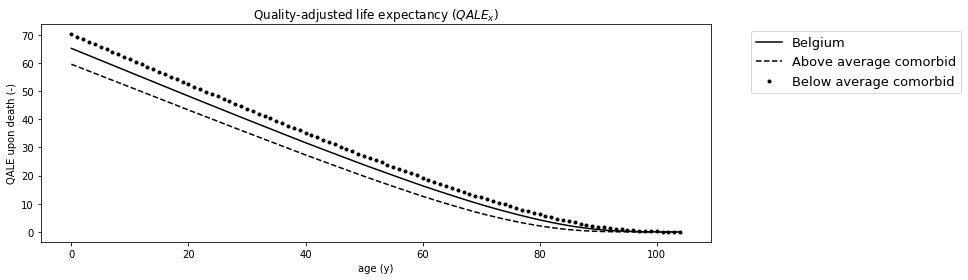

In [8]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_method = 'convergent'
# No comorbidity
ax.plot(QALY_model.compute_QALE_x(population='BE', SMR_method=SMR_method), color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALE_x(population='comorbid_high', SMR_method=SMR_method), '--',color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALE_x(population='comorbid_low', SMR_method=SMR_method), '.',color='black')
ax.set_xlabel('age (y)')
ax.set_ylabel('QALE upon death (-)')
ax.legend(['Belgium', 'Above average comorbid','Below average comorbid'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.set_title('Quality-adjusted life expectancy ($QALE_x$)')
ax.grid(False)
plt.show()

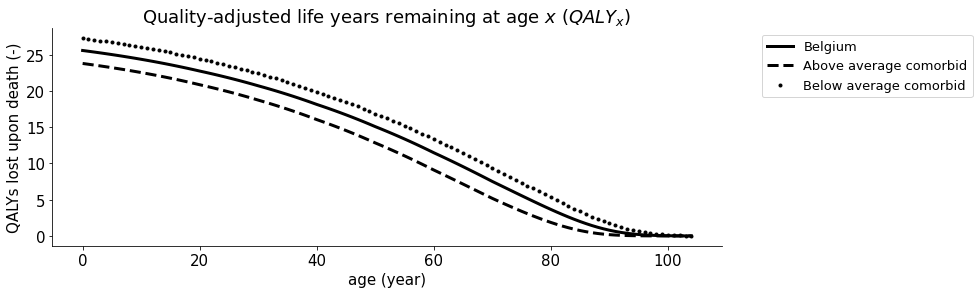

In [10]:
fig,ax = plt.subplots(figsize=(12,4))
SMR_method = 'convergent'
r=0.03
# No comorbidity
ax.plot(QALY_model.compute_QALY_x(population='BE', SMR_method=SMR_method,r=r), color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALY_x(population='comorbid_high', SMR_method=SMR_method,r=r), '--',color='black')
# Comorbidity
ax.plot(QALY_model.compute_QALY_x(population='comorbid_low', SMR_method=SMR_method,r=r), '.',color='black')
ax.set_xlabel('age (year)')
ax.set_ylabel('QALYs lost upon death (-)')
ax.legend(['Belgium', 'Above average comorbid','Below average comorbid'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)
ax.set_title('Quality-adjusted life years remaining at age $x$ ($QALY_x$)')
ax.grid(False)
plt.show()

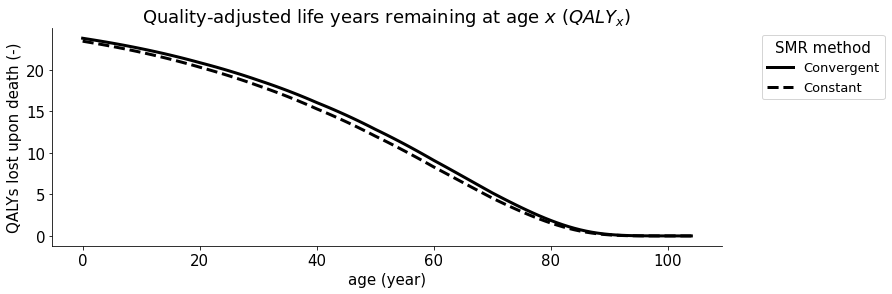

In [11]:
fig,ax = plt.subplots(figsize=(12,4))
r=0.03
# Convergent SMR method
ax.plot(QALY_model.compute_QALY_x(population='comorbid_high', SMR_method='convergent',r=r), color='black')
# Constant SMR method
ax.plot(QALY_model.compute_QALY_x(population='comorbid_high', SMR_method='constant',r=r), '--',color='black')
ax.set_xlabel('age (year)')
ax.set_ylabel('QALYs lost upon death (-)')
ax.legend(['Convergent', 'Constant'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13, title='SMR method')
ax.set_title('Quality-adjusted life years remaining at age $x$ ($QALY_x$)')
ax.grid(False)
plt.show()

## Legacy

###  The effect of hospital care reduction vs. COVID-19
+ In the folowing example, the loss of life due to a constant average percentual reduction in regular hospital is calculated and compared with the overall loss of life to Covid-19.
+ The provided function can be used to investigate the effect of time-dependent changes in hospital care as well as reductions in the treatment of different disease categories.

In [218]:
from covid19model.models.QALY import lost_QALYs_hospital_care

# Define percentual reduction range
reduction_range=np.linspace(0.10,0.99,100)
# Calculate QALYs lost due to hospital care reduction
lost_hospital=lost_QALYs_hospital_care(reduction_range)
# Calculate how much QALYs are lost over a time period delta_T
delta_T = (simtime[-1]-simtime[0])/pd.Timedelta(days=1)
QALY_indirect = lost_hospital*delta_T
# Extract direct QALY loss from model
QALY_direct_mean = np.cumsum(out['QALYs_treatment'].mean(dim="draws").sum(dim="Nc").values)[-1]
QALY_direct_lower = np.cumsum(out['QALYs_treatment'].quantile(conf_int/2,dim="draws").sum(dim="Nc").values)[-1]
QALY_direct_upper = np.cumsum(out['QALYs_treatment'].quantile(1-conf_int/2,dim="draws").sum(dim="Nc").values)[-1]
# Calculate ratio
ratio_mean = QALY_direct_mean/QALY_indirect
ratio_upper = QALY_direct_lower/QALY_indirect
ratio_lower = QALY_direct_upper/QALY_indirect
#ratio_data = sum(deaths*lost_QALY_pp)/QALY_indirect

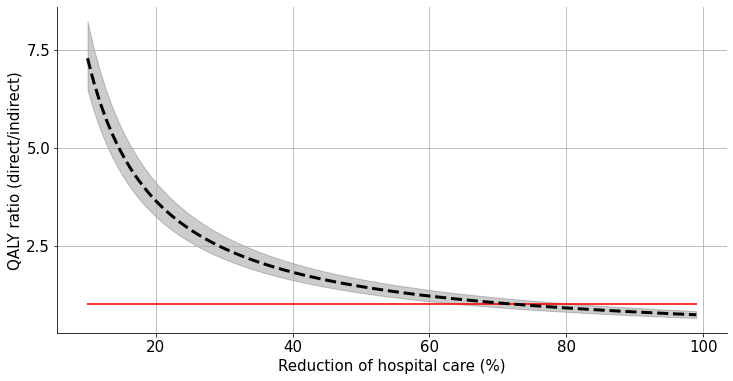

In [219]:
from covid19model.visualization.output import _apply_tick_locator

# Initialize plot
fig,ax = plt.subplots(figsize=(12,6))

# Add lines
ax.plot(reduction_range*100,np.ones(100),color='red',alpha=0.8,linewidth=2)
ax.plot(reduction_range*100,ratio_mean,'--',color='black')
ax.fill_between(reduction_range*100,ratio_lower,ratio_upper,alpha=0.2,color='black')

# limit the number of ticks on the axis
ax = _apply_tick_locator(ax)

# labels and title
ax.set_xlabel('Reduction of hospital care (%)')
ax.set_ylabel('QALY ratio (direct/indirect)')
#plt.title('Comparison of qualitative life years lost\n directly vs. indirectly to SARS-CoV-2')

# save figure
plt.savefig('../../results/QALYs/QALY_ratio.pdf',dpi=300)